# NN cascade for URZ correct nodes
### With normalization of Features as in iwt_nnet.c : iwt_normalize()

* Radek Hofman, Jan 2018

### Imports and axiliary functions and stuff

In [1]:
%load_ext sql
%matplotlib inline

In [2]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open(os.path.join('/','home','hofman','.dbp.txt'), 'r') as f: password = f.read().strip()

In [4]:
query = "oracle://hofman:%s@mycelium.ctbto.org:1521/udb" % password
%sql $query

'Connected: hofman@udb'

In [5]:
% sql select count(*) from ml_features where sta='URZ'

0 rows affected.


COUNT(*)
362407


In [6]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [8]:
#select from database required numbers
wrong_type = %sql select count(*) from ml_features where sta='URZ' and class_phase != class_iphase
total_number = %sql select count(*) from ml_features where sta='URZ' and phase!='N' and source!='M'

0 rows affected.
0 rows affected.


In [9]:
print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

Percentage of misclassified initial wave types: 47.90%


### Dataframes per class phase type

In [10]:
query = """select * from ml_features where sta='URZ' and class_phase='regS'"""
df_S_all = pd.read_sql(query, con=connection)

In [11]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,25050735,URZ,1.125386e+09,Sx,regS,Sn,regS,1.000,A,0.166667,...,1.526004,0.786459,1.174982,-0.1,-0.27,1.216724,0.363039,2.166968,1.844924,0.626604
1,25058004,URZ,1.125423e+09,Lg,regS,Sn,regS,1.925,A,0.444444,...,2.762988,15.337161,15.337161,-0.1,-0.31,0.423843,1.384683,0.724611,6.547078,1.569841
2,25075768,URZ,1.125508e+09,Lg,regS,Sn,regS,1.050,A,0.333333,...,1.395858,1.296030,2.398118,0.0,0.00,0.713705,1.641215,0.940403,1.211333,1.909713
3,25092371,URZ,1.125587e+09,Sn,regS,Sn,regS,0.175,A,0.166667,...,1.746398,5.561389,2.205452,0.0,0.00,1.155050,0.646231,0.997092,1.326985,4.507104
4,25094351,URZ,1.125598e+09,Sn,regS,Sn,regS,1.400,A,0.444444,...,2.816413,5.135686,8.557762,0.0,0.00,1.682028,0.309588,2.783780,8.199625,2.007485


In [12]:
query = """select * from ml_features where sta='URZ' and class_phase='regP'"""
df_P_all = pd.read_sql(query, con=connection)

In [13]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,14972252,URZ,1.069735e+09,Pn,regP,Pn,regP,2.94244,A,0.166667,...,1.542596,0.124299,0.176237,0.1,0.100,0.509125,0.983261,0.619635,0.118464,0.058735
1,14992929,URZ,1.070059e+09,Pn,regP,Pn,regP,0.00000,A,0.333333,...,1.301846,1.112025,0.258914,0.2,0.245,3.730434,0.738458,0.704325,0.247701,0.060989
2,15029724,URZ,1.070386e+09,Pn,regP,Pn,regP,0.65000,A,0.166667,...,1.828008,0.132138,0.192003,0.2,0.375,0.629496,0.632947,0.277982,0.542543,0.041916
3,15031571,URZ,1.070403e+09,Pn,regP,Pn,regP,3.22500,A,0.444444,...,1.375773,0.282216,0.589090,0.1,0.050,0.924411,0.941318,0.304547,0.520954,0.131296
4,15073977,URZ,1.070752e+09,Pg,regP,Pn,regP,0.00000,A,0.166667,...,3.529159,0.085323,0.486815,0.1,0.290,0.211185,0.225393,0.257161,0.413598,0.287086


In [14]:
query = """select * from ml_features where sta='URZ' and class_phase='tele'"""
df_T_all = pd.read_sql(query, con=connection)

In [15]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,28541585,URZ,1.143123e+09,P,tele,P,tele,0.550,A,0.666667,...,1.702892,0.042081,0.042081,0.0,0.000,0.467387,0.594238,0.057473,0.053682,0.463873
1,28556291,URZ,1.143197e+09,P,tele,P,tele,0.500,A,0.333333,...,1.957241,0.223522,0.223522,0.0,0.000,0.954016,0.705002,1.308694,0.193754,0.114283
2,28557837,URZ,1.143204e+09,P,tele,P,tele,3.100,A,0.333333,...,1.190828,0.240041,0.613747,0.0,-0.195,0.577677,1.020239,0.372745,0.277075,0.067225
3,28559193,URZ,1.143210e+09,P,tele,P,tele,0.000,A,0.333333,...,1.531207,0.084376,0.084376,0.1,0.130,0.689514,0.333741,0.336678,0.119060,0.092935
4,28561877,URZ,1.143223e+09,P,tele,P,tele,0.375,A,0.444444,...,2.808070,0.038871,0.097918,0.1,0.205,0.358785,0.042658,0.127151,0.064076,0.062188


In [16]:
query = """select * from ml_features where sta='URZ' and class_phase='N'"""
df_N_all = pd.read_sql(query, con=connection)

In [17]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,13097443,URZ,1.055511e+09,N,N,None,N,0.0,A,0.166667,...,2.948945,9.600216,9.600216,0.0,0.00,0.396880,1.145887,0.421142,0.406116,1.439137
1,13097727,URZ,1.055513e+09,N,N,None,N,0.0,A,0.444444,...,5.750848,9.726424,3.211865,-0.1,-0.04,0.628241,0.617270,0.890586,2.788352,1.279634
2,13097728,URZ,1.055513e+09,N,N,None,N,0.0,A,1.000000,...,1.550819,0.163623,12.531935,0.1,0.50,2.625565,0.419386,0.502452,1.093746,0.228218
3,13097729,URZ,1.055513e+09,N,N,None,N,0.0,A,0.333333,...,2.203439,0.328290,0.511023,-0.1,-0.50,0.532591,1.455946,0.672186,0.730198,0.130826
4,13097946,URZ,1.055517e+09,N,N,None,N,0.0,A,1.000000,...,2.803004,0.827978,0.630203,0.0,0.00,1.039954,0.420590,0.983108,0.450562,0.274970


In [18]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [19]:
#how much data we have
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (11135, 25)
regP (11818, 25)
tele (38083, 25)
noise (301371, 25)


# Definition of input and output

In [20]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [21]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

#sample TPS dataset, random_state is a seed
ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(samp_count, random_state=11)
ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(samp_count, random_state=13)
ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(samp_count, random_state=17)
TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
N_data = df_N_all[df_N_all['SOURCE'] != 'M'].sample(3*samp_count, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(9133, 25) (9133, 25) (9133, 25)
(27399, 25)
(27399, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [22]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [23]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [24]:
import keras.utils

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


### Define train/test ratio

In [25]:
train_test_split_ratio = 0.75
samp_count_train = int(TPS_data_norm.shape[0] * train_test_split_ratio)
samp_count_test = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_test)

train count= 20549 test count= 6850


In [26]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_test = TPS_data_norm[samp_count_train:]

N_train = N_data_norm[:samp_count_train]
N_test = N_data_norm[samp_count_train:]

print('TPS train:',TPS_train.shape,'TPS test:',TPS_test.shape)
print('N train:  ',N_train.shape,  'N test:  ',N_test.shape)

TPS train: (20549, 25) TPS test: (6850, 25)
N train:   (20549, 25) N test:   (6850, 25)


### Check interclass balance of TPS

In [27]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='tele'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_test[TPS_test['CLASS_PHASE']=='tele'].shape)
print('regP in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_test[TPS_test['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (6879, 25)
regP in TPS train: (6885, 25)
regS in TPS train: (6785, 25)
T in TPS test:     (2254, 25)
regP in TPS test:  (2248, 25)
regS in TPS test:  (2348, 25)


### Form train and test sets and shuffle

In [28]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
test =  pd.concat([TPS_test, N_test]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

### Extract features and class labels

In [48]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

test_X = test[x_indices].values.astype(float)
test_Y = test[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
test_Y_ = numpy.array(numpy.where(test_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
test_Y = keras.utils.to_categorical(test_Y_)

test_metadata = test[metadata]

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print(test_metadata.shape)

(41098, 15) (41098, 2) (13700, 15) (13700, 2)
(13700, 9)


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [49]:
train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,tele,0.333333,0.876298,0.850086,0.992758,0.224657,0.367041,1.148829,0.695760,0.1,0.210000,-0.104905,-0.435932,0.226950,0.438466,0.293249
1,N,0.166667,0.724983,0.854786,0.919896,0.818256,0.443154,0.119121,0.119121,0.0,0.000000,-0.379387,0.232105,0.387892,-0.076344,0.207745
2,N,1.000000,0.853112,0.929160,0.645099,0.821087,0.557919,0.088165,-0.062487,0.0,0.000000,0.293835,-0.475917,0.062625,-0.106332,-0.609955
3,tele,0.333333,0.963301,0.978250,0.143203,0.843323,0.299923,-1.193141,-0.982010,0.1,0.230000,-0.325329,-1.110690,-0.928083,-1.152685,-1.283656
4,regS,0.166667,0.765570,0.680203,0.907409,0.913729,0.311822,0.352552,0.136282,0.0,0.000000,0.213465,0.628614,0.641160,0.073407,0.112197
5,N,0.333333,0.925275,0.912522,0.979026,0.127511,0.622694,0.900261,0.823713,-0.1,-0.510000,0.097697,-0.450898,0.163709,0.721411,0.427589
6,tele,0.333333,0.950553,0.908256,0.129385,0.966102,0.237398,-1.140370,-0.767501,0.0,0.000000,-0.237752,-0.323295,0.077786,-0.792014,-1.187756
7,N,1.000000,0.899306,0.910752,0.224614,0.871148,0.461925,-0.767314,-0.533612,0.0,0.000000,0.025681,-0.322970,-0.288431,-0.350781,-0.471402
8,tele,0.333333,0.700953,0.691383,0.345555,0.905487,0.295192,-0.344796,-0.452101,0.0,0.000000,-0.220504,0.049985,-0.049138,-0.278167,-1.459330
9,tele,0.333333,0.984735,0.867906,0.971856,0.316954,0.928498,1.501361,0.520125,0.1,0.450000,-0.313979,0.107318,0.327013,0.284634,0.545984


In [50]:
train_Y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

#### Ground truth for all 4 classes

In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'tele'])
test_Y_GT = le.transform(test[y_indices])
train_Y_GT = le.transform(train[y_indices])
test_Y_GT[:20]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 3, 0, 1, 0, 0, 0, 3, 3, 1, 1, 3, 1, 0, 2, 0, 0, 1, 2])

# Neural network

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [53]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [55]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [56]:
history = {k : [] for k in hist_keys}

In [57]:
h = model.fit(train_X[:], train_Y[:], 
          epochs=500, 
          batch_size=1024, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(test_X, test_Y))

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 41098 samples, validate on 13700 samples
Epoch 1/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.7015 - acc: 0.4353 - val_loss: 0.6968 - val_acc: 0.4432
Epoch 2/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.6952 - acc: 0.4490 - val_loss: 0.6930 - val_acc: 0.4691
Epoch 3/500
41098/41098 [==============================] - 0s 9us/step - loss: 0.6918 - acc: 0.5099 - val_loss: 0.6901 - val_acc: 0.5542
Epoch 4/500
41098/41098 [==============================] - 0s 8us/step - loss: 0.6882 - acc: 0.5903 - val_loss: 0.6863 - val_acc: 0.6161
Epoch 5/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.6832 - acc: 0.6353 - val_loss: 0.6809 - val_acc: 0.6381
Epoch 6/500
41098/41098 [==============================] - 0s 9us/step - loss: 0.6762 - acc: 0.6419 - val_loss: 0.6737 - val_acc: 0.6369
Epoch 7/500
41098/41098 [==============================] - 0s 7us/step - loss: 0.6678 - acc: 0.6585 - val_loss: 0.6654 - val_acc

41098/41098 [==============================] - 0s 5us/step - loss: 0.4182 - acc: 0.8160 - val_loss: 0.4265 - val_acc: 0.8061
Epoch 61/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.4172 - acc: 0.8167 - val_loss: 0.4254 - val_acc: 0.8063
Epoch 62/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.4160 - acc: 0.8171 - val_loss: 0.4245 - val_acc: 0.8065
Epoch 63/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.4150 - acc: 0.8177 - val_loss: 0.4235 - val_acc: 0.8067
Epoch 64/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.4140 - acc: 0.8179 - val_loss: 0.4225 - val_acc: 0.8070
Epoch 65/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.4131 - acc: 0.8184 - val_loss: 0.4217 - val_acc: 0.8073
Epoch 66/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.4121 - acc: 0.8186 - val_loss: 0.4209 - val_acc: 0.8072
Epoch 67/500
41098/41098 [=====================

41098/41098 [==============================] - 0s 6us/step - loss: 0.3858 - acc: 0.8274 - val_loss: 0.3973 - val_acc: 0.8188
Epoch 120/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3856 - acc: 0.8275 - val_loss: 0.3971 - val_acc: 0.8189
Epoch 121/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3853 - acc: 0.8274 - val_loss: 0.3968 - val_acc: 0.8192
Epoch 122/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3850 - acc: 0.8276 - val_loss: 0.3966 - val_acc: 0.8194
Epoch 123/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3848 - acc: 0.8278 - val_loss: 0.3966 - val_acc: 0.8192
Epoch 124/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3846 - acc: 0.8281 - val_loss: 0.3963 - val_acc: 0.8198
Epoch 125/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3844 - acc: 0.8280 - val_loss: 0.3960 - val_acc: 0.8192
Epoch 126/500
41098/41098 [==============

41098/41098 [==============================] - 0s 5us/step - loss: 0.3755 - acc: 0.8314 - val_loss: 0.3880 - val_acc: 0.8236
Epoch 179/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3754 - acc: 0.8316 - val_loss: 0.3877 - val_acc: 0.8234
Epoch 180/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3753 - acc: 0.8319 - val_loss: 0.3877 - val_acc: 0.8239
Epoch 181/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3752 - acc: 0.8316 - val_loss: 0.3878 - val_acc: 0.8234
Epoch 182/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3750 - acc: 0.8321 - val_loss: 0.3875 - val_acc: 0.8238
Epoch 183/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3749 - acc: 0.8319 - val_loss: 0.3873 - val_acc: 0.8238
Epoch 184/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3748 - acc: 0.8319 - val_loss: 0.3873 - val_acc: 0.8242
Epoch 185/500
41098/41098 [==============

Epoch 237/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3701 - acc: 0.8342 - val_loss: 0.3831 - val_acc: 0.8262
Epoch 238/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3700 - acc: 0.8342 - val_loss: 0.3830 - val_acc: 0.8263
Epoch 239/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3700 - acc: 0.8341 - val_loss: 0.3830 - val_acc: 0.8264
Epoch 240/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3699 - acc: 0.8343 - val_loss: 0.3830 - val_acc: 0.8261
Epoch 241/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3698 - acc: 0.8347 - val_loss: 0.3828 - val_acc: 0.8264
Epoch 242/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3698 - acc: 0.8343 - val_loss: 0.3828 - val_acc: 0.8263
Epoch 243/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3697 - acc: 0.8341 - val_loss: 0.3828 - val_acc: 0.8263
Epoch 244/500
41098/41098 [

Epoch 296/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3668 - acc: 0.8364 - val_loss: 0.3802 - val_acc: 0.8277
Epoch 297/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3668 - acc: 0.8363 - val_loss: 0.3801 - val_acc: 0.8275
Epoch 298/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3667 - acc: 0.8361 - val_loss: 0.3801 - val_acc: 0.8275
Epoch 299/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3667 - acc: 0.8363 - val_loss: 0.3800 - val_acc: 0.8278
Epoch 300/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3666 - acc: 0.8363 - val_loss: 0.3800 - val_acc: 0.8279
Epoch 301/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3666 - acc: 0.8365 - val_loss: 0.3800 - val_acc: 0.8276
Epoch 302/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3666 - acc: 0.8364 - val_loss: 0.3799 - val_acc: 0.8276
Epoch 303/500
41098/41098 [

41098/41098 [==============================] - 0s 4us/step - loss: 0.3646 - acc: 0.8371 - val_loss: 0.3779 - val_acc: 0.8282
Epoch 355/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3646 - acc: 0.8373 - val_loss: 0.3778 - val_acc: 0.8284
Epoch 356/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3645 - acc: 0.8371 - val_loss: 0.3778 - val_acc: 0.8285
Epoch 357/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8372 - val_loss: 0.3777 - val_acc: 0.8286
Epoch 358/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3645 - acc: 0.8377 - val_loss: 0.3777 - val_acc: 0.8287
Epoch 359/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3644 - acc: 0.8373 - val_loss: 0.3776 - val_acc: 0.8288
Epoch 360/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3644 - acc: 0.8373 - val_loss: 0.3777 - val_acc: 0.8286
Epoch 361/500
41098/41098 [==============

41098/41098 [==============================] - 0s 5us/step - loss: 0.3628 - acc: 0.8384 - val_loss: 0.3758 - val_acc: 0.8306
Epoch 414/500
41098/41098 [==============================] - 0s 7us/step - loss: 0.3628 - acc: 0.8383 - val_loss: 0.3757 - val_acc: 0.8306
Epoch 415/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3627 - acc: 0.8388 - val_loss: 0.3758 - val_acc: 0.8304
Epoch 416/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3627 - acc: 0.8385 - val_loss: 0.3757 - val_acc: 0.8303
Epoch 417/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3627 - acc: 0.8388 - val_loss: 0.3758 - val_acc: 0.8305
Epoch 418/500
41098/41098 [==============================] - 0s 4us/step - loss: 0.3627 - acc: 0.8386 - val_loss: 0.3756 - val_acc: 0.8304
Epoch 419/500
41098/41098 [==============================] - 0s 5us/step - loss: 0.3626 - acc: 0.8386 - val_loss: 0.3756 - val_acc: 0.8301
Epoch 420/500
41098/41098 [==============

41098/41098 [==============================] - 0s 8us/step - loss: 0.3612 - acc: 0.8395 - val_loss: 0.3736 - val_acc: 0.8314
Epoch 473/500
41098/41098 [==============================] - 0s 8us/step - loss: 0.3612 - acc: 0.8393 - val_loss: 0.3737 - val_acc: 0.8313
Epoch 474/500
41098/41098 [==============================] - 0s 8us/step - loss: 0.3612 - acc: 0.8391 - val_loss: 0.3737 - val_acc: 0.8312
Epoch 475/500
41098/41098 [==============================] - 0s 7us/step - loss: 0.3612 - acc: 0.8397 - val_loss: 0.3736 - val_acc: 0.8311
Epoch 476/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3611 - acc: 0.8395 - val_loss: 0.3736 - val_acc: 0.8312
Epoch 477/500
41098/41098 [==============================] - 0s 6us/step - loss: 0.3610 - acc: 0.8395 - val_loss: 0.3736 - val_acc: 0.8311
Epoch 478/500
41098/41098 [==============================] - 0s 7us/step - loss: 0.3610 - acc: 0.8395 - val_loss: 0.3736 - val_acc: 0.8309
Epoch 479/500
41098/41098 [==============

In [39]:
train_Y[train_Y==0].shape, train_Y[train_Y==1].shape
test_Y[test_Y[:,0]==1].shape, test_Y[test_Y[:,1]==1].shape

((6850, 2), (6850, 2))

In [58]:
test_Y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

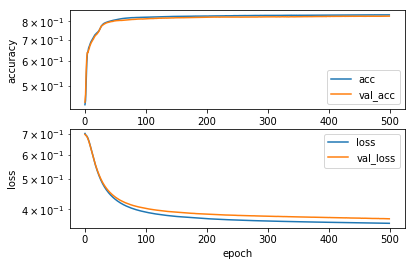

In [59]:
plot(history, semilog=True)

In [60]:
# calculate predicted values
Y_pred_ = model.predict(test_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])

[[0.2206204  0.7795533 ]
 [0.13186947 0.8680657 ]
 [0.4344645  0.5650122 ]
 [0.3533134  0.6464893 ]
 [0.7490016  0.25091422]
 [0.03128402 0.96872073]
 [0.19450949 0.8054433 ]
 [0.2560959  0.7439529 ]
 [0.7416212  0.25845933]
 [0.8907972  0.10906365]]


In [61]:
Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max()

(0.999331, 1.0009164)

In [62]:
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [63]:
from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_, Y_pred)
print(conf_mat)

[[5711 1139]
 [1163 5687]]


In [64]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[17354  3195]
 [ 3405 17144]]


In [65]:
#eval on test data
model.evaluate(test_X, test_Y)

13700/13700 [==============================] - 0s 12us/step


[0.3726936337025496, 0.8318978102189781]

In [66]:
model.evaluate(train_X, train_Y)

41098/41098 [==============================] - 0s 11us/step


[0.36035532819145155, 0.8393839116229692]

In [68]:
#save model and weights, NC = nodes correct
model.save('URZ_model_15-6-2_norm_NC_NTPS.h5')

# Neural network TP vs S 

* we need a new dataset for this

## Dataset for TP vs S

In [69]:
print(TPS_train.shape, TPS_test.shape)

(20549, 25) (6850, 25)


In [74]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

test_X_TPS = TPS_test[x_indices].values.astype(float)
test_Y_TPS = TPS_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
test_Y_TPS_ = numpy.array(numpy.where(test_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
test_Y_TPS = keras.utils.to_categorical(test_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, test_X_TPS.shape, test_Y_TPS.shape)

(20549, 15) (20549, 2) (6850, 15) (6850, 2)


### test if node3 < 0.5 => S

In [75]:
TPS_train[y_indices+x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,regS,0.333333,0.829703,0.733932,0.656072,0.356845,0.304759,0.201781,0.275765,-0.2,-0.175000,-0.136094,-0.464298,-0.132930,0.049345,-0.133097
1,tele,0.333333,0.895752,0.977953,0.006972,0.983441,0.838955,-0.981637,-0.810078,0.1,0.090000,-0.228505,-0.099400,-0.743478,-1.013762,-0.880014
2,regP,0.166667,0.983845,0.967418,0.167897,0.999756,0.402774,-1.273636,-1.329216,0.2,0.315000,-0.310373,-0.182101,-0.163527,-0.844041,-1.027759
3,tele,0.166667,0.986203,0.974063,0.154322,0.822576,0.349078,-1.349539,-1.154446,0.1,0.140000,0.897362,0.112187,-0.106137,-0.735110,-1.124374
4,regP,0.166667,0.982295,0.974180,0.177759,0.979892,0.239376,-1.227335,-1.227335,0.1,0.070000,0.211810,0.194740,-0.119883,-0.102045,-1.348465
5,regP,0.166667,0.838278,0.922653,0.627375,0.661725,0.363572,-0.041421,-0.287866,0.0,0.000000,-0.362823,0.087695,-0.192810,-0.354543,-1.052923
6,tele,0.166667,0.891537,0.949444,0.065309,0.955195,0.469561,-0.942423,-0.942423,0.0,0.000000,0.015178,0.485974,-0.230462,-0.982911,-1.088941
7,regP,0.166667,0.782548,0.860514,0.616115,0.994184,0.255811,-0.017308,-0.354208,0.3,0.363333,-0.293590,-0.216389,-0.443438,-0.238399,-0.893283
8,tele,0.444444,0.933073,0.968623,0.061147,0.966952,0.551731,-1.142040,-0.986672,0.1,0.080000,0.346875,-0.220367,-0.494649,-0.768719,-0.691848
9,tele,0.166667,0.922974,0.869321,0.798127,0.635730,0.635628,0.432552,-0.259575,0.0,0.000000,0.009300,0.569255,-0.207097,-0.120775,-1.436423


In [76]:
train_Y_TPS

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

### Manually added datasets for testing

In [77]:
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)

(6006, 15) (6006, 2) (6006, 1)


#### Manual dataset ground truth

In [79]:
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]

/dvlscratch/SHI/users/hofman/ML/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 3, 1, 2, 3, 3, 2, 2, 1, 3])

### Neural network

In [80]:
history_TPS = {k : [] for k in hist_keys}

In [81]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [82]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [83]:
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=5000, 
          batch_size=1024, 
          verbose=0,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TPS, test_Y_TPS]))

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

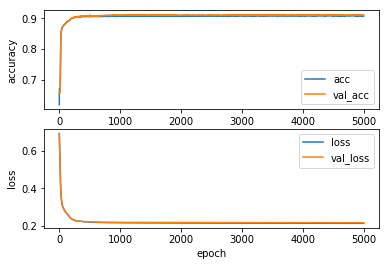

In [84]:
plot(history_TPS)

In [273]:
#NC = nodes correct
model_TPS.save('URZ_model_15-6-2_norm_NC_TPS.h5')

In [86]:
model_TPS.evaluate(test_X_TPS, test_Y_TPS)

6850/6850 [==============================] - 0s 8us/step


[0.21553656952550812, 0.9101459854014599]

#### Test data confusion matrix

In [87]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(test_X_TPS), axis=1), (test_X_TPS.shape[0],1))

# calculate confusion matrix
C = confusion_matrix(test_Y_TPS_, Y_pred)
print(C)

[[4019  483]
 [ 132 2216]]


In [88]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 91.02%


#### Just for curiosity -  Manual associations confusion matrix

In [89]:
Y_pred_man = numpy.argmax(model_TPS.predict(manual_X), axis=1)

# calculate confusion matrix
C = confusion_matrix(manual_Y_TPS_, Y_pred_man)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[3039  965]
 [ 183 1819]]
Accuracy: 80.89%


# Neural network T vs regP 

* we need a new dataset for this

### Dataset for T vs regP

In [95]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_test  = TPS_test [TPS_test ['CLASS_PHASE'] != 'regS']

In [96]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

test_X_TP = TP_test[x_indices].values.astype(float)
test_Y_TP = TP_test[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
test_Y_TP_ = numpy.array(numpy.where(test_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
test_Y_TP = keras.utils.to_categorical(test_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, test_X_TP.shape, test_Y_TP.shape)

(13764, 15) (13764, 2) (4502, 15) (4502, 2)


### test if node5 < 0.5 => P

In [97]:
TP_train[y_indices + x_indices]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
1,tele,0.333333,0.895752,0.977953,0.006972,0.983441,0.838955,-0.981637,-0.810078,0.1,0.090000,-0.228505,-0.099400,-0.743478,-1.013762,-0.880014
2,regP,0.166667,0.983845,0.967418,0.167897,0.999756,0.402774,-1.273636,-1.329216,0.2,0.315000,-0.310373,-0.182101,-0.163527,-0.844041,-1.027759
3,tele,0.166667,0.986203,0.974063,0.154322,0.822576,0.349078,-1.349539,-1.154446,0.1,0.140000,0.897362,0.112187,-0.106137,-0.735110,-1.124374
4,regP,0.166667,0.982295,0.974180,0.177759,0.979892,0.239376,-1.227335,-1.227335,0.1,0.070000,0.211810,0.194740,-0.119883,-0.102045,-1.348465
5,regP,0.166667,0.838278,0.922653,0.627375,0.661725,0.363572,-0.041421,-0.287866,0.0,0.000000,-0.362823,0.087695,-0.192810,-0.354543,-1.052923
6,tele,0.166667,0.891537,0.949444,0.065309,0.955195,0.469561,-0.942423,-0.942423,0.0,0.000000,0.015178,0.485974,-0.230462,-0.982911,-1.088941
7,regP,0.166667,0.782548,0.860514,0.616115,0.994184,0.255811,-0.017308,-0.354208,0.3,0.363333,-0.293590,-0.216389,-0.443438,-0.238399,-0.893283
8,tele,0.444444,0.933073,0.968623,0.061147,0.966952,0.551731,-1.142040,-0.986672,0.1,0.080000,0.346875,-0.220367,-0.494649,-0.768719,-0.691848
9,tele,0.166667,0.922974,0.869321,0.798127,0.635730,0.635628,0.432552,-0.259575,0.0,0.000000,0.009300,0.569255,-0.207097,-0.120775,-1.436423
10,regP,0.166667,0.965188,0.913537,0.098021,0.994014,0.278660,-1.325541,-1.164561,0.1,0.250000,0.467754,-0.602633,-0.624759,-1.387865,-1.366298


In [98]:
train_Y_TP

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

### Neural network

In [99]:
history_TP = {k : [] for k in hist_keys}

In [100]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [101]:
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=1000, 
          #batch_size=32, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([test_X_TP, test_Y_TP]))

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 13764 samples, validate on 4502 samples
Epoch 1/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.6641 - acc: 0.5986 - val_loss: 0.6428 - val_acc: 0.6205
Epoch 2/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.6228 - acc: 0.6487 - val_loss: 0.6010 - val_acc: 0.6727
Epoch 3/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.5796 - acc: 0.6999 - val_loss: 0.5666 - val_acc: 0.7086
Epoch 4/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.5477 - acc: 0.7292 - val_loss: 0.5433 - val_acc: 0.7272
Epoch 5/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.5271 - acc: 0.7484 - val_loss: 0.5294 - val_acc: 0.7448
Epoch 6/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.5136 - acc: 0.7585 - val_loss: 0.5205 - val_acc: 0.7502
Epoch 7/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.5050 - acc: 0.7636 - val_loss: 0.5

13764/13764 [==============================] - 0s 25us/step - loss: 0.4550 - acc: 0.7990 - val_loss: 0.4748 - val_acc: 0.7828
Epoch 60/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4547 - acc: 0.7985 - val_loss: 0.4746 - val_acc: 0.7829
Epoch 61/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4547 - acc: 0.7989 - val_loss: 0.4748 - val_acc: 0.7827
Epoch 62/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4544 - acc: 0.7995 - val_loss: 0.4749 - val_acc: 0.7832
Epoch 63/1000
13764/13764 [==============================] - 0s 31us/step - loss: 0.4543 - acc: 0.7986 - val_loss: 0.4750 - val_acc: 0.7831
Epoch 64/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4542 - acc: 0.7984 - val_loss: 0.4745 - val_acc: 0.7830
Epoch 65/1000
13764/13764 [==============================] - 0s 30us/step - loss: 0.4542 - acc: 0.7987 - val_loss: 0.4763 - val_acc: 0.7842
Epoch 66/1000
13764/13764 [=======

13764/13764 [==============================] - 0s 25us/step - loss: 0.4462 - acc: 0.8050 - val_loss: 0.4689 - val_acc: 0.7853
Epoch 118/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4460 - acc: 0.8048 - val_loss: 0.4713 - val_acc: 0.7875
Epoch 119/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4461 - acc: 0.8053 - val_loss: 0.4697 - val_acc: 0.7875
Epoch 120/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4460 - acc: 0.8058 - val_loss: 0.4686 - val_acc: 0.7858
Epoch 121/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4457 - acc: 0.8058 - val_loss: 0.4689 - val_acc: 0.7859
Epoch 122/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.4456 - acc: 0.8068 - val_loss: 0.4698 - val_acc: 0.7872
Epoch 123/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4454 - acc: 0.8053 - val_loss: 0.4691 - val_acc: 0.7864
Epoch 124/1000
13764/13764 [

13764/13764 [==============================] - 0s 26us/step - loss: 0.4402 - acc: 0.8094 - val_loss: 0.4651 - val_acc: 0.7880
Epoch 176/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.4402 - acc: 0.8101 - val_loss: 0.4648 - val_acc: 0.7876
Epoch 177/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4403 - acc: 0.8097 - val_loss: 0.4648 - val_acc: 0.7872
Epoch 178/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4402 - acc: 0.8085 - val_loss: 0.4648 - val_acc: 0.7876
Epoch 179/1000
13764/13764 [==============================] - 0s 29us/step - loss: 0.4399 - acc: 0.8087 - val_loss: 0.4647 - val_acc: 0.7890
Epoch 180/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4402 - acc: 0.8087 - val_loss: 0.4648 - val_acc: 0.7880
Epoch 181/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4400 - acc: 0.8088 - val_loss: 0.4647 - val_acc: 0.7882
Epoch 182/1000
13764/13764 [

Epoch 233/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4364 - acc: 0.8079 - val_loss: 0.4648 - val_acc: 0.7920
Epoch 234/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4364 - acc: 0.8088 - val_loss: 0.4628 - val_acc: 0.7892
Epoch 235/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4364 - acc: 0.8096 - val_loss: 0.4628 - val_acc: 0.7882
Epoch 236/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4363 - acc: 0.8090 - val_loss: 0.4632 - val_acc: 0.7893
Epoch 237/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4364 - acc: 0.8091 - val_loss: 0.4638 - val_acc: 0.7908
Epoch 238/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4363 - acc: 0.8098 - val_loss: 0.4628 - val_acc: 0.7892
Epoch 239/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4360 - acc: 0.8086 - val_loss: 0.4629 - val_acc: 0.7889
Epoch 240/100

13764/13764 [==============================] - 0s 22us/step - loss: 0.4332 - acc: 0.8098 - val_loss: 0.4626 - val_acc: 0.7900
Epoch 292/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4333 - acc: 0.8107 - val_loss: 0.4624 - val_acc: 0.7901
Epoch 293/1000
13764/13764 [==============================] - 0s 30us/step - loss: 0.4331 - acc: 0.8104 - val_loss: 0.4623 - val_acc: 0.7895
Epoch 294/1000
13764/13764 [==============================] - 1s 46us/step - loss: 0.4331 - acc: 0.8105 - val_loss: 0.4622 - val_acc: 0.7908
Epoch 295/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4330 - acc: 0.8099 - val_loss: 0.4624 - val_acc: 0.7895
Epoch 296/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4330 - acc: 0.8103 - val_loss: 0.4621 - val_acc: 0.7900
Epoch 297/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4329 - acc: 0.8116 - val_loss: 0.4623 - val_acc: 0.7898
Epoch 298/1000
13764/13764 [

13764/13764 [==============================] - 0s 22us/step - loss: 0.4315 - acc: 0.8107 - val_loss: 0.4626 - val_acc: 0.7903
Epoch 350/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4317 - acc: 0.8104 - val_loss: 0.4622 - val_acc: 0.7913
Epoch 351/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4316 - acc: 0.8115 - val_loss: 0.4620 - val_acc: 0.7914
Epoch 352/1000
13764/13764 [==============================] - 0s 20us/step - loss: 0.4317 - acc: 0.8107 - val_loss: 0.4620 - val_acc: 0.7918
Epoch 353/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4317 - acc: 0.8107 - val_loss: 0.4627 - val_acc: 0.7900
Epoch 354/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4316 - acc: 0.8102 - val_loss: 0.4623 - val_acc: 0.7928
Epoch 355/1000
13764/13764 [==============================] - 0s 30us/step - loss: 0.4315 - acc: 0.8118 - val_loss: 0.4627 - val_acc: 0.7916
Epoch 356/1000
13764/13764 [

13764/13764 [==============================] - 0s 26us/step - loss: 0.4309 - acc: 0.8112 - val_loss: 0.4619 - val_acc: 0.7926
Epoch 408/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4307 - acc: 0.8119 - val_loss: 0.4621 - val_acc: 0.7936
Epoch 409/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4307 - acc: 0.8125 - val_loss: 0.4621 - val_acc: 0.7924
Epoch 410/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4306 - acc: 0.8119 - val_loss: 0.4643 - val_acc: 0.7928
Epoch 411/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4306 - acc: 0.8120 - val_loss: 0.4626 - val_acc: 0.7920
Epoch 412/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4307 - acc: 0.8112 - val_loss: 0.4620 - val_acc: 0.7932
Epoch 413/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4306 - acc: 0.8115 - val_loss: 0.4620 - val_acc: 0.7950
Epoch 414/1000
13764/13764 [

13764/13764 [==============================] - 0s 23us/step - loss: 0.4303 - acc: 0.8108 - val_loss: 0.4636 - val_acc: 0.7914
Epoch 466/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4302 - acc: 0.8110 - val_loss: 0.4616 - val_acc: 0.7925
Epoch 467/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4303 - acc: 0.8112 - val_loss: 0.4616 - val_acc: 0.7925
Epoch 468/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4302 - acc: 0.8115 - val_loss: 0.4618 - val_acc: 0.7928
Epoch 469/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4301 - acc: 0.8098 - val_loss: 0.4634 - val_acc: 0.7923
Epoch 470/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4303 - acc: 0.8118 - val_loss: 0.4616 - val_acc: 0.7928
Epoch 471/1000
13764/13764 [==============================] - 0s 31us/step - loss: 0.4301 - acc: 0.8109 - val_loss: 0.4626 - val_acc: 0.7919
Epoch 472/1000
13764/13764 [

13764/13764 [==============================] - 0s 22us/step - loss: 0.4297 - acc: 0.8118 - val_loss: 0.4614 - val_acc: 0.7941
Epoch 524/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4297 - acc: 0.8119 - val_loss: 0.4615 - val_acc: 0.7930
Epoch 525/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4297 - acc: 0.8115 - val_loss: 0.4616 - val_acc: 0.7939
Epoch 526/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4297 - acc: 0.8123 - val_loss: 0.4613 - val_acc: 0.7932
Epoch 527/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4299 - acc: 0.8110 - val_loss: 0.4615 - val_acc: 0.7938
Epoch 528/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4297 - acc: 0.8124 - val_loss: 0.4616 - val_acc: 0.7932
Epoch 529/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4296 - acc: 0.8119 - val_loss: 0.4613 - val_acc: 0.7928
Epoch 530/1000
13764/13764 [

13764/13764 [==============================] - 0s 23us/step - loss: 0.4295 - acc: 0.8111 - val_loss: 0.4611 - val_acc: 0.7939
Epoch 582/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4293 - acc: 0.8120 - val_loss: 0.4611 - val_acc: 0.7945
Epoch 583/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.8120 - val_loss: 0.4610 - val_acc: 0.7943
Epoch 584/1000
13764/13764 [==============================] - 0s 33us/step - loss: 0.4292 - acc: 0.8125 - val_loss: 0.4615 - val_acc: 0.7939
Epoch 585/1000
13764/13764 [==============================] - 0s 30us/step - loss: 0.4293 - acc: 0.8121 - val_loss: 0.4611 - val_acc: 0.7939
Epoch 586/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4292 - acc: 0.8110 - val_loss: 0.4610 - val_acc: 0.7945
Epoch 587/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.4293 - acc: 0.8111 - val_loss: 0.4609 - val_acc: 0.7939
Epoch 588/1000
13764/13764 [

13764/13764 [==============================] - 0s 20us/step - loss: 0.4287 - acc: 0.8108 - val_loss: 0.4608 - val_acc: 0.7948
Epoch 640/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4290 - acc: 0.8120 - val_loss: 0.4607 - val_acc: 0.7948
Epoch 641/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4289 - acc: 0.8113 - val_loss: 0.4608 - val_acc: 0.7943
Epoch 642/1000
13764/13764 [==============================] - 0s 20us/step - loss: 0.4290 - acc: 0.8115 - val_loss: 0.4611 - val_acc: 0.7939
Epoch 643/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4288 - acc: 0.8122 - val_loss: 0.4612 - val_acc: 0.7925
Epoch 644/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4289 - acc: 0.8122 - val_loss: 0.4611 - val_acc: 0.7939
Epoch 645/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4288 - acc: 0.8123 - val_loss: 0.4608 - val_acc: 0.7945
Epoch 646/1000
13764/13764 [

13764/13764 [==============================] - 0s 24us/step - loss: 0.4287 - acc: 0.8112 - val_loss: 0.4605 - val_acc: 0.7945
Epoch 698/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4286 - acc: 0.8123 - val_loss: 0.4606 - val_acc: 0.7943
Epoch 699/1000
13764/13764 [==============================] - 0s 20us/step - loss: 0.4288 - acc: 0.8112 - val_loss: 0.4605 - val_acc: 0.7945
Epoch 700/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4285 - acc: 0.8120 - val_loss: 0.4605 - val_acc: 0.7948
Epoch 701/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4286 - acc: 0.8120 - val_loss: 0.4605 - val_acc: 0.7950
Epoch 702/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4286 - acc: 0.8126 - val_loss: 0.4605 - val_acc: 0.7936
Epoch 703/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4287 - acc: 0.8123 - val_loss: 0.4606 - val_acc: 0.7945
Epoch 704/1000
13764/13764 [

13764/13764 [==============================] - 0s 29us/step - loss: 0.4283 - acc: 0.8112 - val_loss: 0.4609 - val_acc: 0.7934
Epoch 756/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4284 - acc: 0.8131 - val_loss: 0.4603 - val_acc: 0.7952
Epoch 757/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4283 - acc: 0.8119 - val_loss: 0.4616 - val_acc: 0.7945
Epoch 758/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4285 - acc: 0.8125 - val_loss: 0.4609 - val_acc: 0.7941
Epoch 759/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4283 - acc: 0.8121 - val_loss: 0.4613 - val_acc: 0.7939
Epoch 760/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4283 - acc: 0.8116 - val_loss: 0.4603 - val_acc: 0.7956
Epoch 761/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4284 - acc: 0.8123 - val_loss: 0.4604 - val_acc: 0.7952
Epoch 762/1000
13764/13764 [

13764/13764 [==============================] - 0s 22us/step - loss: 0.4283 - acc: 0.8123 - val_loss: 0.4603 - val_acc: 0.7939
Epoch 814/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4282 - acc: 0.8125 - val_loss: 0.4603 - val_acc: 0.7948
Epoch 815/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4281 - acc: 0.8128 - val_loss: 0.4604 - val_acc: 0.7939
Epoch 816/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4283 - acc: 0.8115 - val_loss: 0.4601 - val_acc: 0.7959
Epoch 817/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4281 - acc: 0.8126 - val_loss: 0.4602 - val_acc: 0.7943
Epoch 818/1000
13764/13764 [==============================] - 0s 26us/step - loss: 0.4281 - acc: 0.8123 - val_loss: 0.4603 - val_acc: 0.7943
Epoch 819/1000
13764/13764 [==============================] - 0s 23us/step - loss: 0.4282 - acc: 0.8120 - val_loss: 0.4602 - val_acc: 0.7932
Epoch 820/1000
13764/13764 [

13764/13764 [==============================] - 0s 28us/step - loss: 0.4280 - acc: 0.8118 - val_loss: 0.4600 - val_acc: 0.7939
Epoch 872/1000
13764/13764 [==============================] - 0s 29us/step - loss: 0.4279 - acc: 0.8118 - val_loss: 0.4601 - val_acc: 0.7943
Epoch 873/1000
13764/13764 [==============================] - 0s 33us/step - loss: 0.4279 - acc: 0.8123 - val_loss: 0.4598 - val_acc: 0.7954
Epoch 874/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4279 - acc: 0.8118 - val_loss: 0.4601 - val_acc: 0.7954
Epoch 875/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4281 - acc: 0.8120 - val_loss: 0.4601 - val_acc: 0.7952
Epoch 876/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4279 - acc: 0.8122 - val_loss: 0.4599 - val_acc: 0.7963
Epoch 877/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.4279 - acc: 0.8121 - val_loss: 0.4599 - val_acc: 0.7952
Epoch 878/1000
13764/13764 [

13764/13764 [==============================] - 0s 21us/step - loss: 0.4276 - acc: 0.8128 - val_loss: 0.4597 - val_acc: 0.7959
Epoch 930/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4277 - acc: 0.8126 - val_loss: 0.4597 - val_acc: 0.7948
Epoch 931/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4277 - acc: 0.8125 - val_loss: 0.4597 - val_acc: 0.7948
Epoch 932/1000
13764/13764 [==============================] - 0s 29us/step - loss: 0.4278 - acc: 0.8123 - val_loss: 0.4596 - val_acc: 0.7954
Epoch 933/1000
13764/13764 [==============================] - 1s 38us/step - loss: 0.4276 - acc: 0.8113 - val_loss: 0.4613 - val_acc: 0.7954
Epoch 934/1000
13764/13764 [==============================] - 0s 35us/step - loss: 0.4279 - acc: 0.8121 - val_loss: 0.4598 - val_acc: 0.7956
Epoch 935/1000
13764/13764 [==============================] - 0s 27us/step - loss: 0.4278 - acc: 0.8126 - val_loss: 0.4597 - val_acc: 0.7956
Epoch 936/1000
13764/13764 [

13764/13764 [==============================] - 0s 22us/step - loss: 0.4277 - acc: 0.8128 - val_loss: 0.4595 - val_acc: 0.7939
Epoch 988/1000
13764/13764 [==============================] - 0s 28us/step - loss: 0.4276 - acc: 0.8120 - val_loss: 0.4595 - val_acc: 0.7932
Epoch 989/1000
13764/13764 [==============================] - 0s 25us/step - loss: 0.4276 - acc: 0.8128 - val_loss: 0.4599 - val_acc: 0.7954
Epoch 990/1000
13764/13764 [==============================] - 0s 24us/step - loss: 0.4276 - acc: 0.8119 - val_loss: 0.4596 - val_acc: 0.7970
Epoch 991/1000
13764/13764 [==============================] - 0s 22us/step - loss: 0.4276 - acc: 0.8126 - val_loss: 0.4599 - val_acc: 0.7952
Epoch 992/1000
13764/13764 [==============================] - 0s 21us/step - loss: 0.4276 - acc: 0.8118 - val_loss: 0.4598 - val_acc: 0.7956
Epoch 993/1000
13764/13764 [==============================] - 0s 20us/step - loss: 0.4275 - acc: 0.8114 - val_loss: 0.4595 - val_acc: 0.7956
Epoch 994/1000
13764/13764 [

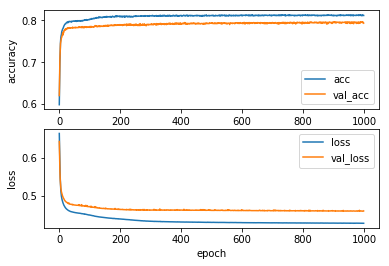

In [102]:
plot(history_TP)

In [272]:
#NC = nodes correct
model_TP.save('URZ_model_15-6-2_norm_NC_TP.h5')

In [104]:
model_TP.evaluate(test_X_TP, test_Y_TP)

4502/4502 [==============================] - 0s 17us/step


[0.45997298121293456, 0.7934251444861922]

#### Test data confusion matrix

In [105]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(test_X_TP), axis=1), (test_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(test_Y_TP_, Y_pred)
print(conf_mat)

[[1723  531]
 [ 399 1849]]


# Cascade of all three models

In [304]:
from keras.models import load_model

In [292]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_TP.h5')

In [298]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # N
    Y[S_indices] = 2 # regS
    Y[P_indices] = 1 # regP 
    Y[T_indices] = 3 # tele
    
    return Y
    

In [299]:
Y = predict_iwt(test_X)

### Overall confusion matrix for test data

In [300]:
test_X.shape, Y.shape, test_Y_GT.shape

((13700, 15), (13700,), (13700,))

In [301]:
C = confusion_matrix(Y, test_Y_GT)
print(C)

[[5687  238  609  292]
 [ 346 1687   14  473]
 [ 653    5 1651  374]
 [ 164  318   74 1115]]


In [302]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 74.01%


#### Let's produce result data frame from metadata and results

In [161]:
class_dict = {0:'N', 1:'regP', 2:'regS', 3:'tele'}
Y_pred_cat = [class_dict[yi] for yi in Y]
print(len(Y_pred_cat))

13700


In [162]:
test_metadata = test[metadata]

In [163]:
#let's add new column to the pandas dataframe
#test_metadata['CLASS_IPHASE_NEW'] = Y_pred_cat  # deprecated - gives warning
test_metadata.assign(CLASS_IPHASE_NEW = pd.Series(Y_pred_cat, index=test_metadata.index)).to_csv('test_set_prediction.txt', na_rep='null',columns=metadata+["CLASS_IPHASE_NEW"]) 

In [ ]:
### some experiment section..

In [306]:
test_pred_Y = predict_iwt(test_X)

In [314]:
test_X.shape
train_X.shape

(41098, 15)

In [308]:
test_iphase_Y = le.transform(test['CLASS_IPHASE'])
test_truth_Y = le.transform(test['CLASS_PHASE'])

In [310]:
test_truth_Y.min(), test_truth_Y.max()

(0, 3)

In [311]:
test_iphase_Y.min(), test_iphase_Y.max()

(0, 3)

In [ ]:
numpy.sum( ) 

In [317]:
#print('IPHASE:')
C = confusion_matrix(test_pred_Y, test_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[5687  238  609  292]
 [ 346 1687   14  473]
 [ 653    5 1651  374]
 [ 164  318   74 1115]]
Accuracy: 74.01%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [164]:
test_TPS = test[test['CLASS_PHASE'] != 'N']
test_TPS_X = test_TPS[x_indices]
test_TPS_pred_Y = predict_iwt(test_TPS_X)
test_TPS_truth_Y = le.transform(test_TPS['CLASS_PHASE'])
test_TPS_iphase_Y = le.transform(test_TPS['CLASS_IPHASE'])

In [165]:
test_TPS_iphase_Y.min(), test_TPS_iphase_Y.max()

(0, 3)

In [166]:
print('IPHASE:')
C = confusion_matrix(test_TPS_iphase_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

IPHASE:
[[   0  337  829  380]
 [   0 1655  170  540]
 [   0   45 1312  351]
 [   0  211   37  983]]
Accuracy: 57.66%


In [167]:
print('NEW PREDICTION')
C = confusion_matrix(test_TPS_pred_Y, test_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

NEW PREDICTION
[[   0  238  609  292]
 [   0 1687   14  473]
 [   0    5 1651  374]
 [   0  318   74 1115]]
Accuracy: 65.01%


* in the test data, the current iwt characterized 1501 as NOISE (first row of confusion matrix)
* our new iwt would characterize 1089 as NOISE
* after re-training, accuracy on the test set rose from 58.68% to 65.82% for regS, regP and T phases

#### ..on train data just to see if it works

In [168]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[17144   681  1621   893]
 [ 1009  5296    24  1317]
 [ 1886    20  4931  1186]
 [  510   888   209  3483]]
Accuracy: 75.07%


### Overall confusion matrix for all manual associations (no Noise)

In [169]:
C = confusion_matrix(predict_iwt(manual_X, stage=1), manual_Y_GT)
print(C)

Skipping N, classifying TPS only
[[1308   68  394]
 [ 229 1819  736]
 [ 465  115  872]]


In [170]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 66.58%


## Let's try all noise samples we have

In [171]:
# let's get all noise phases not used for training
N_data_diff = pd.concat([df_N_all, N_data]).loc[
    df_N_all.index.symmetric_difference(N_data.index)
]

In [172]:
print(N_data_diff.shape, df_N_all.shape, N_data.shape)
print(N_data_diff.shape[0], 'should equal', df_N_all.shape[0]-N_data.shape[0])

(273972, 25) (301371, 25) (27399, 25)
273972 should equal 273972


In [173]:
N_data_norm = N_data_diff[x_indices].copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(df_N_all['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(df_N_all['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(df_N_all['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(df_N_all['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(df_N_all['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(df_N_all['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(df_N_all['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(df_N_all['HTOV5'])

In [174]:
N_data_norm.shape

(273972, 15)

In [175]:
N_X = N_data_norm[x_indices].values.astype(float)
N_Y = numpy.zeros(N_X.shape[0])

print(N_X.shape, N_Y.shape)

(273972, 15) (273972,)


In [176]:
Y = predict_iwt(N_X)
C = confusion_matrix(Y, N_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[226601      0      0      0]
 [ 14624      0      0      0]
 [ 25745      0      0      0]
 [  7002      0      0      0]]
Accuracy: 82.71%


* From all avaibale noise phases which were not used for training we are able to correctly identify 83.8%

# Let's analyze weights and generate a new weight file!

In [274]:
model_NTPS = load_model('URZ_model_15-6-2_norm_NC_NTPS.h5')
model_STP = load_model('URZ_model_15-6-2_norm_NC_TPS.h5')
model_PT = load_model('URZ_model_15-6-2_norm_NC_TP.h5')

In [275]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [276]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'batch_input_shape': (None, 15),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_3',
   'trainable': True,
   'units': 6,
   'use_bias': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'sigmoid',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kern

In [277]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [278]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[ 3.0968304e+00 -6.2974734e+00 -6.0831946e-01  3.3535042e-01
   7.3604131e-01 -5.1173096e+00]
 [ 1.5893496e+00  5.9721166e-01  3.0018559e-01 -3.7043059e-01
   1.4576182e+00  1.8395895e+00]
 [ 8.1926721e-01  1.9752675e-01  2.5312366e+00  5.3096199e-01
  -3.5982567e-01  3.2447159e+00]
 [-3.6883567e-02 -9.6345270e-01 -2.4427168e+00 -1.5438526e+00
  -2.7777711e-01 -4.3399863e+00]
 [-3.1460006e+00  8.1218439e-01  1.3475110e-01  1.3429914e+00
   8.1348144e-02  3.8094811e+00]
 [ 7.9141688e-01 -9.4347733e-01 -1.2419647e+00  8.0076642e-02
  -4.3333632e-01 -7.6197380e-01]
 [ 8.4127265e-01  6.0071838e-01  5.4882258e-01  2.1394522e+00
   3.4600765e-01  2.6178579e+00]
 [-7.1985970e+00  3.0666075e+00 -2.3497241e+00 -1.5398337e+00
   5.2326065e-01 -1.7296457e+00]
 [-9.0053434e+00 -2.4356239e+00 -1.4334965e+00  1.5572799e+00
   1.1707560e+00 -2.6465592e-01]
 [ 1.1615269e+00  7.3884091e+00  9.1120631e-01 -2.4208775e+00
   1.7806054e+00  1.4888449e+00]
 [-1.0096141e+00  6.5410084e-01  3.0025646

In [279]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[-4.3343186e+00 -1.3297454e+00  1.3434204e+01 -2.1856134e+00
   2.3028407e-01  1.6430157e+00]
 [ 6.0653180e-01 -4.5222077e-01 -1.5330170e+00  3.5276824e-01
  -1.9227149e+00 -2.4453971e+00]
 [-1.3291728e+00 -2.9051635e+00  3.3752039e-01 -1.0292636e+00
   1.7666313e-01  9.6791750e-01]
 [-9.8054534e-01  8.9465481e-01 -1.3053843e+00 -9.5680672e-01
  -7.8966961e+00 -1.5717601e+00]
 [ 5.5053496e-01  6.5853506e-01 -1.9370100e+00  1.1448896e+00
  -1.9921190e-01  4.0188032e-01]
 [-2.1095469e+00  9.5903254e-01  7.0435876e-01  2.2798316e+00
  -3.0110271e+00 -9.4721055e-01]
 [ 5.8626592e-01 -9.2940539e-01 -1.4385526e-01 -5.8406287e-01
  -2.2411005e-01  1.1940055e+00]
 [ 1.5824299e-02  2.0358088e+00  9.3259200e-02  7.5488722e-01
  -6.4224154e-01 -6.3099217e-01]
 [ 3.5099022e+00  3.5581011e-01  7.5784688e+00  2.9768522e+00
   2.9937739e+00 -8.1714973e+00]
 [ 1.3947524e+01 -9.7597486e-01  2.3631625e+00 -1.6984946e+00
  -1.8858331e+00 -6.2410712e-01]
 [ 5.0232202e-01 -1.4293006e-01  2.6400593

### Let's export it to a weigth file using a template

In [286]:
station_name = 'URZ'

In [287]:
# open template
with open(os.path.join('templates','%s.template' % station_name)) as f:
    template = f.read()
    #print(s)

In [288]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

In [289]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [290]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [291]:
print(s)

*-- URZ.nn
*-- Comments ...
*-- Auxiliary 3C station URZ uses the new weights from retraining by RH
*-- Generated 2018/03/01 14:03:33
*-- {{training_summary}}
URZ
3
60.000000
  0.25   0.50   1.00   2.00   4.00
URZ TPS-N
628 3 16 7 2
-2.376368 -0.927079 0.028574 2.904464 -2.757271 -1.935304
-0.191346 4.051755 1.413869 0.624177 0.207417 1.420089
-0.180812 -2.573530 0.729465 -0.681179 0.570158 0.958584
-1.278597 -0.526079 -2.246546 0.778902 -1.163404 -1.092274
-1.898848 -2.574765 -0.639069 0.227027 -2.255667 0.494329
-0.975701 1.124619 0.238758 0.842130 -0.524736 -0.131241
-0.404206 -0.089438 0.093127 1.365064 2.619826 -0.238154
-1.269986 0.988002 0.199616 0.266871 -0.923373 0.576104
0.614613 -0.511615 0.422346 1.290045 -0.445179 -0.448549
3.853374 -0.962503 2.460750 -5.204453 4.308048 10.046413
0.130815 0.663980 -4.139403 -0.264204 -0.831771 1.013826
-0.172663 0.247883 0.169815 0.090731 0.724148 -0.175524
-1.957182 -1.185950 0.356313 -0.064343 0.720119 -0.315432
-3.777756 -0.243621 1.908

In [303]:
#save it
with open(os.path.join('nn_weights','%s.nn' % station_name), 'w+') as f:
    f.write(s)